#### Assessing Marketplace Accessibility: Isochrones for Marketplaces and Supermarkets in Quezon City

Janssens & Sezer (2013). Marketplaces as an Urban Development Strategy (Editorial). Built Environment, 39: 10.2148/benv.39.2.169

Markets act as:
- commercial gathering places
- vivid & inclusive public spaces
- nexus of flows of people, goods, and information
- sources of: 
    - fresh & affordable food, 
    - economic opportunities, and 
    - chances to socialize
- engines for sustainable urban growth
- sites to get a pulse of a city
- domains of public discontent & dispute
- sites of congestion, chaos, illegality
- romantic images for late capitalist urban gentrification
- centers of social movements and grassroots initiatives

#### Where the Jobs Are: Analysis of Office Density in Metro Manila

##### Research Questions:
- What is the distribution of office buildings in Metro Manila?
- What are the dominant clusters of office space in Metro Manila?
- How much office space is there per city in Metro Manila?

Step 0: Set Up Workspace

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as cx

In [3]:
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

Step 1: Data Acquisition

To start, we will first extract all map features with an `office` tag.

In [4]:
# Define place name as Metro Manila
PLACE_NAME = ("Metro Manila, Philippines")

In [5]:
# # Extract Metro Manila boundary polygon
# area = ox.geocode_to_gdf(PLACE_NAME)
# area

In [6]:
# area.plot()

In [7]:
# Extract all offices in Metro Manila
offices = ox.features_from_place(
    PLACE_NAME,
    {
        "office": True
    }
)

In [8]:
offices.head()

addr:city addr:postcode             addr:street  \
element_type osmid                                                          
node         25389013     Parañaque          1701          Quirino Avenue   
             255049849          NaN           NaN                     NaN   
             255049916  Quezon City          1105  Judge Juan Luna Street   
             255050295  Quezon City          1100                     NaN   
             255050658    Parañaque           NaN                     NaN   

                                                                  name  \
element_type osmid                                                       
node         25389013                                             PLDT   
             255049849                     Bayan-bayanan Barangay Hall   
             255049916             Bureau of Telecommunications Office   
             255050295  National Food Authority Center District Office   
             255050658                   Luzon Aggregates Incorporated   

                                   office                    geometry barrier  \
element_type osmid                                                              
node         25389013   telecommunication  POINT (120.99583 14.51609)     NaN   
             255049849         government  POINT (120.94416 14.67649)     NaN   
             255049916         government  POINT (121.02047 14.64995)     NaN   
             255050295         government  POINT (121.01968 14.64097)     NaN   
             255050658            company  POINT (121.04252 14.47150)     NaN   

                         amenity          government is_in:city  ...  \
element_type osmid                                               ...   
node         25389013        NaN                 NaN        NaN  ...   
             255049849  townhall      administrative    Malabon  ...   
             255049916       NaN  telecommunications        NaN  ...   
             255050295       NaN                 NaN        NaN  ...   
             255050658       NaN                 NaN        NaN  ...   

                       addr:borough is_in office_name building:name  \
element_type osmid                                                    
node         25389013           NaN   NaN         NaN           NaN   
             255049849          NaN   NaN         NaN           NaN   
             255049916          NaN   NaN         NaN           NaN   
             255050295          NaN   NaN         NaN           NaN   
             255050658          NaN   NaN         NaN           NaN   

                       backup_generator addr:subdistrict trade operator:phone  \
element_type osmid                                                              
node         25389013               NaN              NaN   NaN            NaN   
             255049849              NaN              NaN   NaN            NaN   
             255049916              NaN              NaN   NaN            NaN   
             255050295              NaN              NaN   NaN            NaN   
             255050658              NaN              NaN   NaN            NaN   

                       ways type  
element_type osmid                
node         25389013   NaN  NaN  
             255049849  NaN  NaN  
             255049916  NaN  NaN  
             255050295  NaN  NaN  
             255050658  NaN  NaN  

[5 rows x 266 columns]

Next, let us examine the data and see which information is most relevant. We can drop the columns we don't need.

In [9]:
offices.shape

(3160, 266)

In [10]:
offices.columns.values

array(['addr:city', 'addr:postcode', 'addr:street', 'name', 'office',
       'geometry', 'barrier', 'amenity', 'government', 'is_in:city',
       'is_in:region', 'is_in:zip', 'opening_hours', 'townhall:type',
       'source:url', 'addr:province', 'osm_id', 'timestamp', 'source',
       'admin_level', 'name:en', 'name:tl', 'official_name', 'website',
       'wikidata', 'wikipedia', 'building', 'military', 'addr:state',
       'short_name', 'garmin:description', 'contact:phone', 'old_name',
       'country', 'diplomatic', 'embassy', 'name:fr', 'target',
       'addr:quarter', 'addr:street:corner', 'denomination', 'religion',
       'addr:housename', 'branch', 'addr:housenumber', 'contact:website',
       'fee', 'healthcare', 'healthcare:speciality', 'indoor', 'note',
       'operator', 'operator:type', 'phone', 'wheelchair', 'alt_name',
       'smoking', 'addr:district', 'access', 'air_conditioning', 'brand',
       'brand:facebook', 'brand:website', 'brand:wikidata',
       'brand:wikip

In [11]:
offices.isna().sum()

addr:city           2021
addr:postcode       2518
addr:street         1315
name                 102
office                 0
                    ... 
addr:subdistrict    3159
trade               3159
operator:phone      3158
ways                3136
type                3136
Length: 266, dtype: int64

In [12]:
offices["nodes"].isna().sum()

2522

In [13]:
na_cutoff = len(offices) * 0.75

In [14]:
drop_cols = []

for col in offices:
    if offices[col].isna().sum() >= na_cutoff:
        drop_cols.append(col)

offices.drop(columns=drop_cols, inplace=True)

In [15]:
offices.columns.values

array(['addr:city', 'addr:street', 'name', 'office', 'geometry'],
      dtype=object)

In [16]:
offices.isna().sum()

addr:city      2021
addr:street    1315
name            102
office            0
geometry          0
dtype: int64

In [17]:
offices.head()

addr:city             addr:street  \
element_type osmid                                            
node         25389013     Parañaque          Quirino Avenue   
             255049849          NaN                     NaN   
             255049916  Quezon City  Judge Juan Luna Street   
             255050295  Quezon City                     NaN   
             255050658    Parañaque                     NaN   

                                                                  name  \
element_type osmid                                                       
node         25389013                                             PLDT   
             255049849                     Bayan-bayanan Barangay Hall   
             255049916             Bureau of Telecommunications Office   
             255050295  National Food Authority Center District Office   
             255050658                   Luzon Aggregates Incorporated   

                                   office                    geometry  
element_type osmid                                                     
node         25389013   telecommunication  POINT (120.99583 14.51609)  
             255049849         government  POINT (120.94416 14.67649)  
             255049916         government  POINT (121.02047 14.64995)  
             255050295         government  POINT (121.01968 14.64097)  
             255050658            company  POINT (121.04252 14.47150)

Let us plot the offices on a map to see what we have. But first, let's ensure that the CRS is pseudo-mercator for web-mapping.

In [18]:
offices.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
offices.to_crs("EPSG:3857", inplace=True)

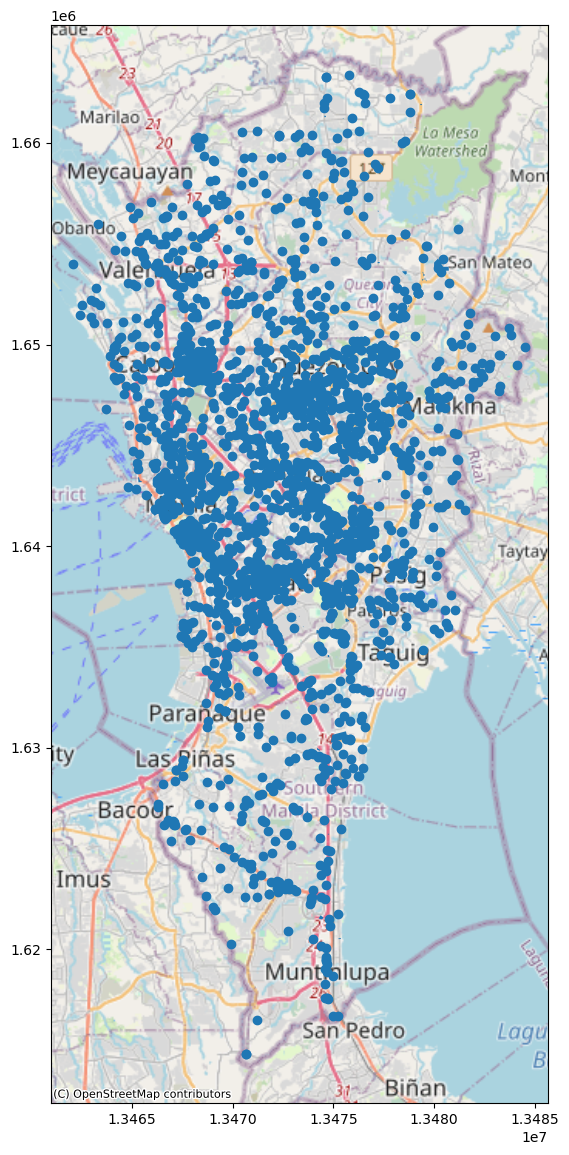

In [20]:
ax = offices.plot(
    figsize=(8,14),
    legend=True
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

In [22]:
# Get coordinates of office points
coords = offices.get_coordinates()
coords

x             y
element_type osmid                                
node         25389013   1.346919e+07  1.633494e+06
             255049849  1.346344e+07  1.651945e+06
             255049916  1.347194e+07  1.648891e+06
             255050295  1.347185e+07  1.647858e+06
             255050658  1.347439e+07  1.628367e+06
...                              ...           ...
relation     16999340   1.347789e+07  1.645840e+06
             16999340   1.347786e+07  1.645767e+06
             16999340   1.347784e+07  1.645725e+06
             16999340   1.347773e+07  1.645775e+06
             16999340   1.347771e+07  1.645828e+06

[7560 rows x 2 columns]

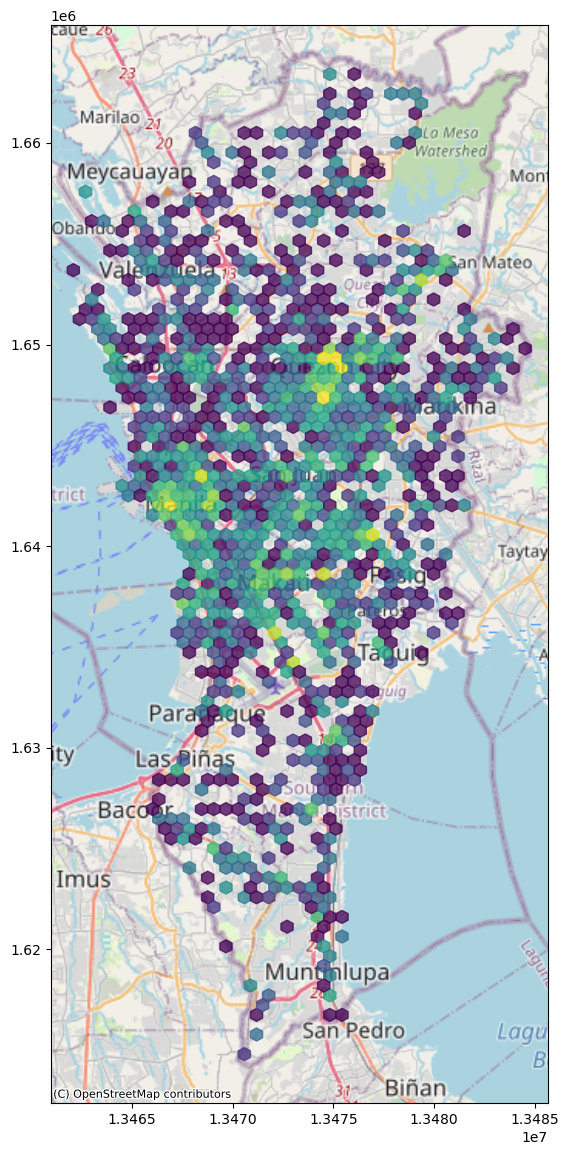

In [40]:
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8,14))

ax2.hexbin(
    coords.x,
    coords.y,
    gridsize=(37, 50),
    bins="log",
    alpha=0.75
)
cx.add_basemap(ax2, source=cx.providers.OpenStreetMap.Mapnik)